In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainerCallback, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_dataset
from copy import deepcopy
import torch

os.environ["WANDB_DISABLED"] = "true"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

RANDOM_STATE = 42

In [2]:
id2label = {0: "CORRECT", 1: "BUGGY"}
label2id = {"CORRECT": 0, "BUGGY": 1}

In [3]:
tokenizer = AutoTokenizer.from_pretrained('dipudl/codet5-base')
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
#                                                            num_labels=2,
#                                                            id2label=id2label,
#                                                            label2id=label2id)

model = AutoModelForSequenceClassification.from_pretrained('dipudl/wrong-binary-operator-bug-distilbert-model',
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/148k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [13]:
!pip install huggingface_hub
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('XXXXXX')"

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


-----
## Load Dataset
-----

In [14]:
train_df = pd.read_csv("/kaggle/input/wrong-binary-operator-dataset-train-test/wrong_binary_operator_dataset_filtered_train.csv", sep="\t")
test_df = pd.read_csv("/kaggle/input/wrong-binary-operator-dataset-train-test/wrong_binary_operator_dataset_filtered_test.csv", sep="\t")

In [15]:
train_df.sample(5)

,file,left,operator,right,type_left,type_right,parent,grandparent,start_line,start_column,end_line,end_column,labels
970395,cleaned/psychtoolbox-3/PsychSourceGL/Source/OS...,numEntries,<<,1,int,int,IF_STMT,COMPOUND_STMT,901,6,901,20,1
678511,cleaned/rdis/src/rdg.c,rdg_node_center_x(rdg_node),-=,10,int,int,VAR_DECL,DECL_STMT,1423,18,1423,50,1
249261,cleaned/msm7x30-3.4.x-naa/fs/notify/fanotify/f...,inode_mark,&&,vfsmnt_mark,struct fsnotify_mark *,struct fsnotify_mark *,IF_STMT,COMPOUND_STMT,184,6,184,31,0
370311,cleaned/freebsd/tools/tools/vxge/vxge_info.c,atoi(argv[5]),<=,3,int,int,PAREN_EXPR,BINARY_OPERATOR,199,38,199,56,0
295947,cleaned/msm7x30-3.4.x-naa/drivers/xen/grant-ta...,req_entries,/,(grefs_per_grant_frame-1),unsigned int,unsigned int,PAREN_EXPR,BINARY_OPERATOR,1025,12,1025,51,1


In [16]:
test_df.sample(5)

,file,left,operator,right,type_left,type_right,parent,grandparent,start_line,start_column,end_line,end_column,labels
9674,cleaned/fis-gtm/sr_port_cm/gtcmtr_zprevious.c,kcur,<,ktop,unsigned char *,unsigned char *,FOR_STMT,COMPOUND_STMT,84,62,84,73,0
83160,cleaned/fis-gtm/sr_unix/get_command_line.c,'r',==,TOLOWER(*cp),int,int,IF_STMT,COMPOUND_STMT,50,9,50,28,0
69157,cleaned/blensor/source/blender/editors/mesh/ed...,index,<=,data->lastIndex,float,float,IF_STMT,COMPOUND_STMT,354,7,354,31,0
44242,cleaned/msm7x30-3.4.x-naa/arch/sparc/kernel/ti...,usec,*,1000,unsigned long,unsigned long,UNEXPOSED_EXPR,RETURN_STMT,208,9,208,20,0
109643,cleaned/feosmusic/codecs/aac/source/sbrhfadj.c,band,<<,bandEnd,int,int,FOR_STMT,COMPOUND_STMT,206,25,206,39,1


In [17]:
train_df.shape, test_df.shape

((1000786, 13), (111200, 13))

In [18]:
train_df.isna().sum()

file            0
left            0
operator        0
right           0
type_left       0
type_right      0
parent          0
grandparent     0
start_line      0
start_column    0
end_line        0
end_column      0
labels          0
dtype: int64

In [19]:
train_df['full_text'] = train_df['left'] + tokenizer.sep_token + train_df['operator'] + tokenizer.sep_token + train_df['right'] + tokenizer.sep_token + train_df['type_left'] + tokenizer.sep_token + train_df['type_right'] + tokenizer.sep_token + train_df['parent'] + tokenizer.sep_token + train_df['grandparent']
test_df['full_text'] = test_df['left'] + tokenizer.sep_token + test_df['operator'] + tokenizer.sep_token + test_df['right'] + tokenizer.sep_token + test_df['type_left'] + tokenizer.sep_token + test_df['type_right'] + tokenizer.sep_token + test_df['parent'] + tokenizer.sep_token + test_df['grandparent']

In [20]:
train_df.drop(['left','operator','right','type_left','type_right','parent', 'grandparent'], axis=1, inplace=True)
test_df.drop(['left','operator','right','type_left','type_right','parent', 'grandparent'], axis=1, inplace=True)

In [21]:
train_df.sample(5)

,file,start_line,start_column,end_line,end_column,labels,full_text
613086,cleaned/mame-os-x/mame/src/mame/video/malzak.c,42,11,42,16,1,512</s>*=</s>2</s>int</s>int</s>COMPOUND_ASSIG...
68975,cleaned/msm7x30-3.4.x-naa/drivers/s390/char/co...,468,8,468,30,1,raw->head</s>%</s>raw->count</s>int</s>int</s>...
435909,cleaned/acc/tdt/cvs/driver/player2/linux/compo...,273,6,273,49,0,OS_TaskNameTable[FreeEntry].Name[0]</s>==</s>'...
841465,cleaned/r-source/src/nmath/polygamma.c,468,11,468,20,0,s</s>-</s>xdmln</s>double</s>double</s>BINARY_...
671443,cleaned/ur-quan-mods/src/libs/graphics/sdl/2xs...,212,9,212,14,0,y</s>+</s>2</s>int</s>int</s>BINARY_OPERATOR</...


In [22]:
test_df.sample(5)

,file,start_line,start_column,end_line,end_column,labels,full_text
65942,cleaned/openwolf/src/tools/bspc/l_qfiles.c,188,34,188,44,0,filter</s>+</s>1</s>char *</s>int</s>PAREN_EXP...
55699,cleaned/taulabs/matlab/ins/insgps.c,1616,17,1616,28,1,-q0</s>+</s>Be[0]</s>float</s>float</s>BINARY_...
102709,cleaned/taulabs/matlab/ins/insgps.c,533,7,533,24,1,F[5][9]</s>-</s>D[2][9]</s>float</s>float</s>B...
64583,cleaned/cci/src/util/argv.c,72,35,72,62,1,(argc+2)</s>-</s>sizeof(char*)</s>unsigned lon...
5754,cleaned/ox820-2.6-linux/drivers/net/wireless/w...,955,12,955,27,1,ring_ptr</s><<</s>0xff</s>int</s>int</s>CALL_E...


In [23]:
# FOR TESTING PURPOSE
# train_df = train_df.sample(int(train_df.shape[0] * 0.01))
# test_df = test_df.sample(int(test_df.shape[0] * 0.01))

In [24]:
print(train_df.iloc[10].full_text)
print("-" * 80)
print(tokenizer.tokenize(train_df.iloc[10].full_text))
print("-" * 80)
print(tokenizer(train_df.iloc[10].full_text))

usec</s>-</s>1000</s>unsigned long</s>unsigned long</s>BINARY_OPERATOR</s>COMPOUND_STMT
--------------------------------------------------------------------------------
['usec', '</s>', '-', '</s>', '1000', '</s>', 'unsigned', 'Ġlong', '</s>', 'unsigned', 'Ġlong', '</s>', 'BINARY', '_', 'OPER', 'ATOR', '</s>', 'COMP', 'OUND', '_', 'STMT']
--------------------------------------------------------------------------------
{'input_ids': [1, 7380, 2, 117, 2, 2369, 2, 688, 1018, 2, 688, 1018, 2, 11022, 167, 3531, 5747, 2, 2322, 17844, 167, 13997, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
def tokenize_text(examples):
    return tokenizer(examples["full_text"], truncation=True, max_length=128, padding=True)

In [26]:
train_df, validation_df = train_test_split(train_df, test_size=0.11111, random_state=RANDOM_STATE)
train_df.shape, validation_df.shape

((889588, 7), (111198, 7))

In [27]:
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'full_text', '__index_level_0__'],
    num_rows: 889588
})

In [28]:
validation_dataset = Dataset.from_pandas(validation_df)
validation_dataset

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'full_text', '__index_level_0__'],
    num_rows: 111198
})

In [29]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'full_text'],
    num_rows: 111200
})

-----
## Tokenization
-----

In [30]:
train_dataset = train_dataset.map(tokenize_text, batched=True, remove_columns=["full_text", "__index_level_0__"])
train_dataset

  0%|          | 0/890 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 889588
})

In [31]:
validation_dataset = validation_dataset.map(tokenize_text, batched=True, remove_columns=["full_text", "__index_level_0__"])
validation_dataset

  0%|          | 0/112 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 111198
})

In [32]:
test_dataset = test_dataset.map(tokenize_text, batched=True, remove_columns=["full_text"])
test_dataset

  0%|          | 0/112 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'start_line', 'start_column', 'end_line', 'end_column', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 111200
})

In [33]:
def softmax(x):
    result = np.zeros_like(x)
    
    for i in range(len(x)):
        result[i] = np.exp(x[i]) / np.sum(np.exp(x[i]), axis=0)
    return result

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # loss = log_loss(labels, softmax(preds))
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

-----
## Model Training
-----

In [35]:
# ! rm -rd /kaggle/working/codeT5-DistilBERT-wrong-binary-operator-bug-model

batch_size = 64
logging_steps = len(train_dataset) // batch_size
output_dir = "wrong-binary-operator-bug-distilbert-model"

training_args = TrainingArguments(output_dir,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  save_strategy="epoch",
                                  # save_steps=10000,
                                  # fp16=True,
                                  push_to_hub=False,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False
                                )

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [36]:
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer, test_dataset) -> None:
        super().__init__()
        self._trainer = trainer
        self.test_dataset = test_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            # control_copy = deepcopy(control)
            # print("Epoch:", state.epoch)
            # print(self._trainer.predict(self._trainer.train_dataset, metric_key_prefix="train").metrics)
            # print(self._trainer.predict(self._trainer.eval_dataset, metric_key_prefix="eval").metrics)
            # print(self._trainer.predict(self.test_dataset, metric_key_prefix="test").metrics)
            
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            self._trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
            # return control_copy

In [37]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,      # number of evaluations to wait before stopping
    early_stopping_threshold=0.01,  # threshold for relative improvement in metric
)

-----
## Hyperparameter Tuning: Learning Rate and Batch Size
-----

In [ ]:
learning_rates = [0.002, 0.0002, 0.00002, 0.000002]
batch_sizes = [32, 64]

# Loop over the learning rates and batch sizes
for lr in learning_rates:
    for bs in batch_sizes:
        # Update the learning rate in the TrainingArguments
        training_args.learning_rate = lr
        training_args.per_device_train_batch_size = bs
        training_args.per_device_eval_batch_size = bs

        # Create a new Trainer with the updated TrainingArguments
        trainer = Trainer(
            model=model,                         
            args=training_args,                  
            train_dataset=train_dataset,         
            eval_dataset=validation_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping]
        )

        # Train the model and evaluate it on the validation set
        trainer.train()
        print(trainer.evaluate())

-----
## Choosing Best Hyperparameters and Training Final Model
-----

In [38]:
# ! rm -rd /kaggle/working/function-args-swap-bug-distilbert-model

BEST_LEARNING_RATE = 2e-5
BEST_BATCH_SIZE = 64
training_args.learning_rate = BEST_LEARNING_RATE
training_args.push_to_hub = False
training_args.per_device_train_batch_size = BEST_BATCH_SIZE
training_args.per_device_eval_batch_size = BEST_BATCH_SIZE


trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.add_callback(CustomCallback(trainer, test_dataset))

In [ ]:
trainer.train()

In [ ]:
# trainer.save("final-wbob-model")

----
## Model Testing
----

In [ ]:
prediction = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: start_line, start_column, end_line, file, end_column. If start_line, start_column, end_line, file, end_column are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 111200
  Batch size = 64


In [ ]:
prediction

In [ ]:
labels = prediction.label_ids
labels

In [73]:
preds = prediction.predictions.argmax(-1)
preds

array([0, 0, 1, ..., 1, 0, 0])

In [74]:
f1_score(labels, preds)

0.8369110415315035

In [75]:
preds_probability = softmax(prediction.predictions)
positive_preds_probability = preds_probability[:, 1]

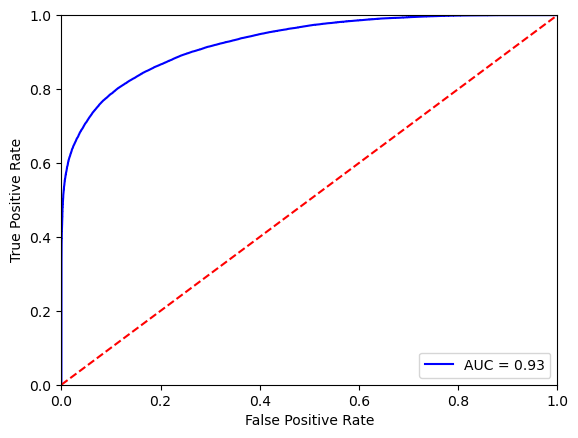

In [76]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(labels, positive_preds_probability)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

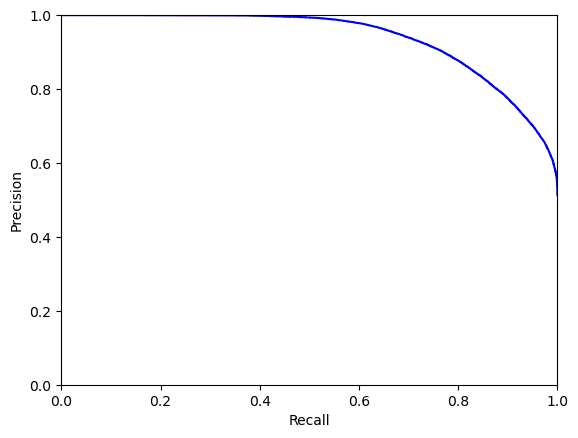

In [77]:
precision, recall, threshold = metrics.precision_recall_curve(labels, positive_preds_probability)

# plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [78]:
test_df

,file,left,operator,right,type_left,type_right,parent,grandparent,start_line,start_column,end_line,end_column,labels
0,cleaned/poropy/poropy/nucleardata/nucleardata_...,cWABA92[11],*,"pow(R,3)",double,double,BINARY_OPERATOR,BINARY_OPERATOR,482,248,482,268,0
1,cleaned/quagga/lib/plist.c,maxseq,<,pentry->seq,int,int,IF_STMT,COMPOUND_STMT,389,11,389,31,0
2,cleaned/c30-linux/pic30-binutils/acme/gas/conf...,"strcasecmp(start,""a2"")",>,0,int,int,IF_STMT,IF_STMT,1221,14,1221,43,1
3,cleaned/fontforge/fontforge/scstylesui.c,100.0,*,hs->counter_percent,double,<dependent type>,CALL_EXPR,COMPOUND_STMT,2729,30,2729,56,0
4,cleaned/open-watcom/bld/wv/c/dlgscomp.c,last,/,first,unsigned int,unsigned int,BINARY_OPERATOR,COMPOUND_STMT,92,15,92,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111195,cleaned/uhub/src/adc/message.c,*str,>=,'\\',int,int,IF_STMT,IF_STMT,913,13,913,25,1
111196,cleaned/blensor/source/blender/editors/space_s...,barh,+,1,int,int,BINARY_OPERATOR,FOR_STMT,431,18,431,26,1
111197,cleaned/freebsd/sys/cddl/contrib/opensolaris/u...,1,&,epbs,int,int,VAR_DECL,DECL_STMT,480,13,480,22,1
111198,cleaned/drone/lib/ffmpeg/libavcodec/jrevdct.c,d00,+,d10,int,int,PAREN_EXPR,BINARY_OPERATOR,1115,25,1115,34,0


In [79]:
test_df["predictions"] = preds

In [80]:
test_df

,file,left,operator,right,type_left,type_right,parent,grandparent,start_line,start_column,end_line,end_column,labels,predictions
0,cleaned/poropy/poropy/nucleardata/nucleardata_...,cWABA92[11],*,"pow(R,3)",double,double,BINARY_OPERATOR,BINARY_OPERATOR,482,248,482,268,0,0
1,cleaned/quagga/lib/plist.c,maxseq,<,pentry->seq,int,int,IF_STMT,COMPOUND_STMT,389,11,389,31,0,0
2,cleaned/c30-linux/pic30-binutils/acme/gas/conf...,"strcasecmp(start,""a2"")",>,0,int,int,IF_STMT,IF_STMT,1221,14,1221,43,1,1
3,cleaned/fontforge/fontforge/scstylesui.c,100.0,*,hs->counter_percent,double,<dependent type>,CALL_EXPR,COMPOUND_STMT,2729,30,2729,56,0,0
4,cleaned/open-watcom/bld/wv/c/dlgscomp.c,last,/,first,unsigned int,unsigned int,BINARY_OPERATOR,COMPOUND_STMT,92,15,92,27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111195,cleaned/uhub/src/adc/message.c,*str,>=,'\\',int,int,IF_STMT,IF_STMT,913,13,913,25,1,1
111196,cleaned/blensor/source/blender/editors/space_s...,barh,+,1,int,int,BINARY_OPERATOR,FOR_STMT,431,18,431,26,1,0
111197,cleaned/freebsd/sys/cddl/contrib/opensolaris/u...,1,&,epbs,int,int,VAR_DECL,DECL_STMT,480,13,480,22,1,1
111198,cleaned/drone/lib/ffmpeg/libavcodec/jrevdct.c,d00,+,d10,int,int,PAREN_EXPR,BINARY_OPERATOR,1115,25,1115,34,0,0


In [81]:
positive_probabilities = softmax(prediction.predictions)[:, 1]
positive_probabilities

array([3.4660680e-04, 2.7619913e-01, 9.9996412e-01, ..., 9.9778658e-01,
       2.8760633e-01, 3.3463329e-01], dtype=float32)

In [82]:
test_df["positive_probabilities"] = positive_probabilities
test_df

,file,left,operator,right,type_left,type_right,parent,grandparent,start_line,start_column,end_line,end_column,labels,predictions,positive_probabilities
0,cleaned/poropy/poropy/nucleardata/nucleardata_...,cWABA92[11],*,"pow(R,3)",double,double,BINARY_OPERATOR,BINARY_OPERATOR,482,248,482,268,0,0,0.000347
1,cleaned/quagga/lib/plist.c,maxseq,<,pentry->seq,int,int,IF_STMT,COMPOUND_STMT,389,11,389,31,0,0,0.276199
2,cleaned/c30-linux/pic30-binutils/acme/gas/conf...,"strcasecmp(start,""a2"")",>,0,int,int,IF_STMT,IF_STMT,1221,14,1221,43,1,1,0.999964
3,cleaned/fontforge/fontforge/scstylesui.c,100.0,*,hs->counter_percent,double,<dependent type>,CALL_EXPR,COMPOUND_STMT,2729,30,2729,56,0,0,0.030901
4,cleaned/open-watcom/bld/wv/c/dlgscomp.c,last,/,first,unsigned int,unsigned int,BINARY_OPERATOR,COMPOUND_STMT,92,15,92,27,1,1,0.997550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111195,cleaned/uhub/src/adc/message.c,*str,>=,'\\',int,int,IF_STMT,IF_STMT,913,13,913,25,1,1,0.999986
111196,cleaned/blensor/source/blender/editors/space_s...,barh,+,1,int,int,BINARY_OPERATOR,FOR_STMT,431,18,431,26,1,0,0.349923
111197,cleaned/freebsd/sys/cddl/contrib/opensolaris/u...,1,&,epbs,int,int,VAR_DECL,DECL_STMT,480,13,480,22,1,1,0.997787
111198,cleaned/drone/lib/ffmpeg/libavcodec/jrevdct.c,d00,+,d10,int,int,PAREN_EXPR,BINARY_OPERATOR,1115,25,1115,34,0,0,0.287606


In [60]:
# ! rm -rd /kaggle/working/WBO_test_dataset_predictions.csv

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove '/kaggle/working/WBO_test_dataset_predictions.csv': No such file or directory


In [83]:
test_df.to_csv("WBO_test_dataset_predictions.csv", sep="\t", index=False)

-----
## Inference using pipeline
-----

In [85]:
from transformers import pipeline

In [122]:
bug_classifier = pipeline(model="dipudl/wrong-binary-operator-bug-distilbert-model")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

loading configuration file https://huggingface.co/dipudl/wrong-binary-operator-bug-distilbert-model/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d6b37b96a0c9e9cb56be799f4c310ea25a36cb63bfc427359948b409468f8bfc.a116d9a536f536877bd70c89cfbc9d7879686ce296b9546fdbd15f6ce9687340
Model config DistilBertConfig {
  "_name_or_path": "dipudl/wrong-binary-operator-bug-distilbert-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "CORRECT",
    "1": "BUGGY"
  },
  "initializer_range": 0.02,
  "label2id": {
    "BUGGY": 1,
    "CORRECT": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true

In [123]:
result = bug_classifier(list(test_df.full_text[:10]))
result

[{'label': 'CORRECT', 'score': 0.9996533393859863},
 {'label': 'CORRECT', 'score': 0.7238007187843323},
 {'label': 'BUGGY', 'score': 0.9999641180038452},
 {'label': 'CORRECT', 'score': 0.9690993428230286},
 {'label': 'BUGGY', 'score': 0.9975500702857971},
 {'label': 'BUGGY', 'score': 0.9999874830245972},
 {'label': 'CORRECT', 'score': 0.715232789516449},
 {'label': 'BUGGY', 'score': 0.9958478212356567},
 {'label': 'BUGGY', 'score': 0.6763699650764465},
 {'label': 'CORRECT', 'score': 0.9364230632781982}]